In [ ]:
# Ameya Baxi (some collaboration with lab team members)
# COMP SCI 320: Data Science Programming II, Fall 2022
# Project 5: EDGAR Web Logs

# analyzing data from EDGAR web logs (database of reports from public companies to Securities and Exchange Commission)
# project instructions: https://github.com/cs320-wisc/f22/tree/main/p5

# 

In [1]:
# project: p5
# submitter: abaxi
# partner: none
# hours: 20

In [2]:
import pandas as pd, edgar_utils as edgar, re, os, geopandas as gpd, matplotlib.pyplot as plt
from zipfile import ZipFile
from graphviz import Digraph
from shapely.geometry import Polygon, Point, box

In [3]:
with ZipFile("server_log.zip", "r") as f:
    file = f.filename
    rows_csv = pd.read_csv(file)

In [4]:
# add column to rows_csv with region of each IP address

index = -1

rows_csv["region"] = None
rows_csv["hour"] = None
rows_csv["file"] = None

for ip in rows_csv["ip"]:
    index += 1
    region = edgar.lookup_region(ip)
    hour = int(rows_csv.loc[index, ("time")][:2])
    rows_csv.loc[index:index+1, ("region")] = region
    rows_csv.loc[index:index+1, ("hour")] = hour

In [5]:
#Q1
# What's the total size in bytes of the files requested?

size = 0

for row in rows_csv["size"]:
    size += row
    
size = int(size)

# answer
size

24801002666

In [6]:
#Q2
# How many filings have been accessed by the top ten IPs?

ip_freq = rows_csv["ip"].value_counts()

# answer
ip_freq[:10].to_dict()

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

In [7]:
#Q3
# What fraction of the requests had errors?

# code >= 400 is considered an error

count_total = 0 # variable to count total number of requests
count_errors = 0 # variable to count number of requests with errors

for row in rows_csv["code"]:
    count_total += 1
    if row >= 400:
        count_errors += 1

# calculate fraction of requests that had errors
fraction_errors = count_errors / count_total

# answer
fraction_errors

0.03466852724527611

In [8]:
#Q4
# What is the most frequently accessed file?

files_logs = []
c = -1

for row in rows_csv["cik"]:
    c += 1
    file_name = str(int(row)) + "/" + str(rows_csv["accession"][c]) + "/" + str(rows_csv["extention"][c])
    files_logs.append(file_name)
    rows_csv.loc[c:c+1, ("file")] = file_name
                 
files_logs = pd.Series(files_logs)
file_freq = files_logs.value_counts()

# answer
file_freq.keys()[0]

'1627631/0001627631-15-000004/.txt'

In [9]:
#Q5
# How many requests were made by automated crawlers?

count_crawlers = 0 # variable to count total number of requests made by automated crawlers

for row in rows_csv["crawler"]:
    if row == 1.0:
        count_crawlers += 1

# answer
count_crawlers

971

In [10]:
#Q6
# Which region uses EDGAR most heavily?

region_freq = rows_csv["region"].value_counts()

# answer
region_freq.keys()[0]

'United States of America'

In [11]:
#Q7
# What fraction of IPs in each region are high-volume users?

high_vol_users = {} # dictionary with keys region and values fraction of high-volume users
ip_count = {} # dictionary with keys region and values number of IP addresses
high_vol_ip_count = {}
count = -1

for ip in ip_freq.keys():
    count += 1
    # copied from: https://www.statology.org/pandas-get-index-of-row/
    idx = rows_csv.index[rows_csv["ip"] == ip].to_list()[0]
    region = rows_csv["region"][idx]
    if region not in ip_count:
        ip_count[region] = 0
    ip_count[region] += 1
    if region not in high_vol_ip_count:
        high_vol_ip_count[region] = 0
    if ip_freq[count] > 1000:
        high_vol_ip_count[region] += 1
        
for region in ip_count:
    high_vol_users[region] = high_vol_ip_count[region] / ip_count[region]
    
high_vol_users

{'United States of America': 0.019862490450725745,
 'China': 0.006864988558352402,
 'India': 0.058823529411764705,
 'United Kingdom of Great Britain and Northern Ireland': 0.06666666666666667,
 'Korea (Republic of)': 0.2,
 'Canada': 0.017857142857142856,
 'France': 0.0036900369003690036,
 'Bulgaria': 0.3333333333333333,
 'Ireland': 0.3125,
 'Australia': 0.07692307692307693,
 'Hong Kong': 0.0,
 'Germany': 0.0,
 'Czechia': 0.0,
 'Estonia': 0.0,
 'Viet Nam': 0.0,
 'Poland': 0.0,
 'Netherlands': 0.0,
 '-': 0.0,
 'Slovakia': 0.0,
 'Russian Federation': 0.0,
 'Spain': 0.0,
 'Indonesia': 0.0,
 'Ukraine': 0.0,
 'Croatia': 0.0,
 'Italy': 0.0,
 'Taiwan (Province of China)': 0.0,
 'Virgin Islands (British)': 0.0,
 'Liberia': 0.0,
 'Singapore': 0.0,
 'Denmark': 0.0,
 'Romania': 0.0,
 'Luxembourg': 0.0,
 'Switzerland': 0.0,
 'Israel': 0.0,
 'Philippines': 0.0,
 'Egypt': 0.0,
 'Brazil': 0.0,
 'Honduras': 0.0,
 'Greece': 0.0,
 'Sweden': 0.0,
 'Japan': 0.0,
 'Cyprus': 0.0,
 'Latvia': 0.0,
 'Thailand':

In [12]:
# dictionary of Filing objects from docs.zip

filing = dict()
files = []
html_files = []

with ZipFile("docs.zip", "r") as f:
    files = f.filelist
    for file in files:
        file = file.filename
        if file[-4:] == ".htm" or file[-5:] == ".html":
            html_file = f.open(file)
            html = html_file.read()
            html = str(html)
            filing[file] = edgar.Filing(html)

In [13]:
#Q8
# What dates appear in the 850693/0000850693-07-000159/-index.htm file of docs.zip?

#answer
filing["850693/0000850693-07-000159/-index.htm"].dates

['2007-07-25', '2007-07-25', '2007-07-23']

In [14]:
#Q9
# What is the distribution of states for the filings in docs.zip?

states = {}

for file in filing:
    state = filing[file].state()
    if state == None:
        continue
    if state not in states:
        states[state] = 0
    states[state] += 1

# copied from https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
states = dict(sorted(states.items(), key=lambda item: item[1], reverse = True))

#answer
states

{'CA': 91,
 'NY': 83,
 'TX': 64,
 'MA': 30,
 'CO': 25,
 'IL': 25,
 'PA': 25,
 'NJ': 23,
 'FL': 21,
 'VA': 15,
 'MN': 15,
 'CT': 14,
 'MD': 13,
 'MI': 11,
 'OH': 10,
 'DE': 10,
 'NC': 9,
 'WI': 9,
 'GA': 8,
 'OK': 7,
 'OX': 6,
 'NV': 6,
 'IA': 6,
 'UT': 5,
 'KS': 5,
 'AZ': 5,
 'IN': 4,
 'TN': 4,
 'MO': 4,
 'WA': 3,
 'KY': 2,
 'NE': 2,
 'LA': 2,
 'OR': 2,
 'WV': 2,
 'MS': 1,
 'AL': 1,
 'SD': 1,
 'NM': 1,
 'AR': 1,
 'VT': 1,
 'ID': 1,
 'DC': 1,
 'ME': 1}

In [15]:
#Q10
# What is the distribution of SIC codes for the filings in docs.zip?

sic = {}

for file in filing:
    sic_code = filing[file].sic
    if sic_code == None:
        continue
    if sic_code not in sic:
        sic[sic_code] = 0
    sic[sic_code] += 1
    
sic

{2834: 40,
 6022: 20,
 1311: 20,
 6189: 17,
 6211: 17,
 8731: 2,
 1389: 19,
 7370: 7,
 3571: 1,
 7361: 1,
 3674: 5,
 4931: 5,
 1040: 2,
 2810: 2,
 7389: 11,
 3140: 1,
 7374: 4,
 6200: 1,
 7381: 1,
 3620: 3,
 3841: 6,
 4941: 1,
 5621: 1,
 7330: 1,
 6199: 8,
 6798: 20,
 2510: 4,
 3990: 2,
 1700: 5,
 7371: 6,
 5940: 2,
 4522: 5,
 1731: 2,
 6311: 2,
 8082: 2,
 2836: 13,
 6021: 20,
 1000: 11,
 4911: 8,
 6324: 2,
 8051: 1,
 6035: 4,
 3550: 1,
 4813: 4,
 6321: 2,
 2890: 1,
 3845: 2,
 2860: 8,
 1221: 2,
 3669: 2,
 6411: 1,
 5900: 2,
 2320: 1,
 6221: 3,
 6331: 10,
 2070: 1,
 8742: 5,
 3829: 3,
 900: 5,
 5500: 2,
 7372: 11,
 6770: 1,
 4841: 2,
 4833: 1,
 7384: 1,
 6799: 3,
 3826: 5,
 8711: 2,
 5160: 1,
 5944: 1,
 3420: 3,
 3510: 3,
 5960: 1,
 3842: 4,
 8062: 3,
 6029: 11,
 7320: 1,
 5172: 2,
 1382: 2,
 3663: 4,
 1400: 3,
 7822: 1,
 2024: 1,
 2080: 1,
 7812: 2,
 4922: 2,
 2030: 1,
 3576: 3,
 2711: 1,
 3578: 1,
 3679: 2,
 2842: 1,
 4899: 1,
 100: 1,
 3541: 1,
 7311: 1,
 3317: 1,
 2033: 1,
 3721: 1

In [16]:
#Q11
# What is the distribution of requests across industries?

industry = dict()

for file in files_logs:
    if file in filing:
        file_sic = filing[file].sic
        if file_sic == None:
            continue
        if file_sic not in industry:
            industry[file_sic] = 0
        industry[file_sic] += 1
        
# copied from https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
industry = dict(sorted(industry.items(), key=lambda item: item[1], reverse = True))

#answer
industry

{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 6022: 379,
 1000: 273,
 6211: 237,
 7371: 229,
 2860: 226,
 6021: 204,
 6282: 171,
 2510: 171,
 3825: 164,
 4841: 108,
 5621: 99,
 7200: 94,
 7374: 94,
 6331: 91,
 6798: 90,
 5311: 90,
 3842: 87,
 6221: 85,
 6029: 83,
 3272: 81,
 3829: 73,
 4931: 70,
 3510: 66,
 7830: 62,
 3826: 56,
 3695: 55,
 3620: 50,
 7373: 48,
 6799: 46,
 4412: 43,
 4512: 42,
 7340: 40,
 7370: 39,
 900: 39,
 6513: 38,
 3621: 38,
 5172: 36,
 5900: 35,
 4213: 35,
 3990: 34,
 5122: 34,
 5944: 33,
 2070: 33,
 8090: 32,
 1700: 31,
 3312: 31,
 1381: 31,
 4922: 31,
 6324: 30,
 8742: 27,
 7389: 26,
 8731: 25,
 7812: 25,
 3590: 24,
 4955: 23,
 3663: 23,
 4522: 22,
 6321: 21,
 3559: 20,
 5812: 19,
 6792: 19,
 6189: 18,
 7372: 16,
 3841: 14,
 6199: 11,
 1731: 11,
 4911: 8,
 4833: 7,
 6035: 7,
 3571: 6,
 2430: 6,
 3679: 5,
 3674: 5,
 4813: 4,
 3678: 4,
 4812: 4,
 1531: 4,
 5500: 4,
 6411: 3,
 1400: 3,
 2800: 3,
 3420: 3,
 8062: 3,
 3576: 3,
 2870: 2,
 1040: 2,
 8711: 2,
 3669: 

In [17]:
#Q12
# How many requests were made in each hour?

requests_per_hour = rows_csv["hour"].value_counts().sort_index().to_dict()

# answer
requests_per_hour

{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

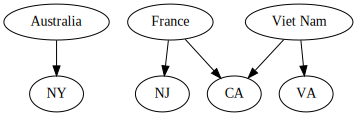

In [18]:
#Q13
# What is the geographic overlap in interest between Australia, France, and Viet Nam?

overlap = Digraph()

countries = ["Australia", "France", "Viet Nam"]
country_states = dict()

for country in countries:
    overlap.node(country)
    
index = -1
for file in rows_csv["file"]:
    index += 1
    r = rows_csv.loc[index, ("region")]
    if r in countries:
        if file in filing:
            file_state = filing[file].state()
            if r not in country_states:
                country_states[r] = set()
            if file_state not in country_states[r]:
                overlap.edge(r, file_state)
                country_states[r].add(file_state) 
                
# answer                
overlap

In [19]:
#Q14
# What are the most commonly seen street addresses?

street_addresses = []
common = dict()

for file in rows_csv["file"]:
    if file in filing:
        addresses = filing[file].addresses
        for address in addresses:
            address = address.replace("\n\\n", "\n")
            street_addresses.append(address)

address_counts = pd.Series(street_addresses).value_counts()
address_counts = address_counts.to_dict()

for address in address_counts:
    if address_counts[address] >= 225:
        common[address] = address_counts[address]

# answer
common

{'801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 720,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102\n817-334-4100': 464,
 '1114 AVENUE OF THE AMERICAS\n29TH FLOOR\nNEW YORK NY 10036': 356,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104': 305,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383': 289,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383\n425-442-0931': 289,
 '1881 GROVE AVENUE\nRADFORD VA 24141': 277,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104\n3125066500': 264,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020': 225,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020\n212-956-2221': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3\n604-683-6332': 225}

/home/ameyabaxi/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


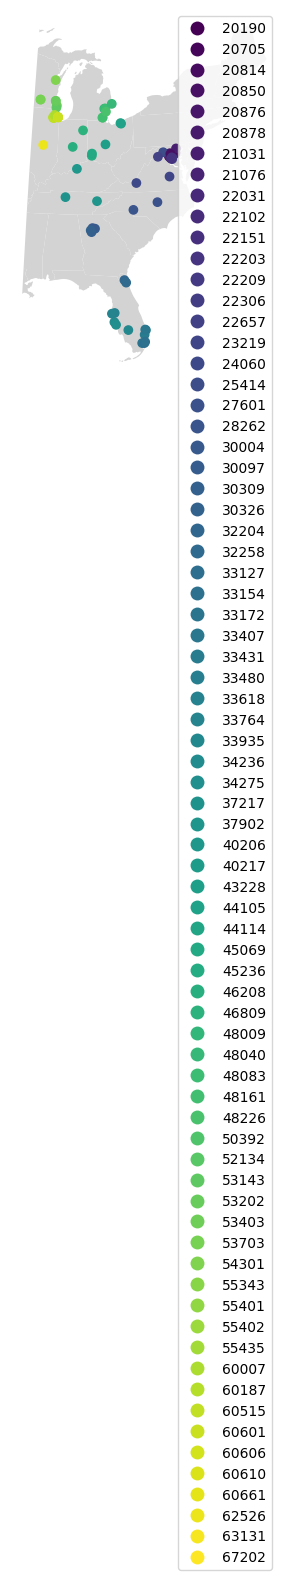

In [20]:
#Q15
# geographic plotting of postal code

window = box(-90, 20, -55, 50)

states_df = gpd.read_file("shapes/cb_2018_us_state_20m.shp")
states_df = states_df.intersection(window)
states_df = states_df.to_crs("epsg:2022")

locations = gpd.read_file("locations.geojson")
locations["postal code"] = None
index = 0

for location in locations["address"]:
    postal_code = None
    if re.findall("\d{5}$", location) != []:
        postal_code = float(re.findall("\d{5}$", location)[0])
    elif re.findall("\d{5}-\d{4}$", location) != []:
        postal_code = float(re.findall("\d{5}-\d{4}$", location)[0][:5])
    if postal_code != None and (20000 <= postal_code <= 70000):
        postal_code = float(postal_code)
    else:
        postal_code = None
    locations.loc[index:index+1, ("postal code")] = postal_code
    index += 1     

locations = locations.dropna() 
locations_2 = locations.intersection(window)
locations_2 = locations_2.to_crs(states_df.crs)

# copied from Stack Exchange: https://gis.stackexchange.com/questions/266098/how-to-convert-a-geoseries-to-a-geodataframe-with-geopandas
locations_3 = gpd.GeoDataFrame(geometry = gpd.GeoSeries(locations_2))
locations_3["postal code"] = locations["postal code"]
# copied from https://pynative.com/pandas-reset-index/#:~:text=df.drop_duplicates()-,Use%20DataFrame.reset_index()%20function,of%20numbers%20starting%20at%200.
locations_3 = locations_3.reset_index()
locations_2.to_crs(states_df.crs)

states_plot = states_df.plot(facecolor = "lightgray")
#loc_plot = locations_3.plot(ax = states_plot, column = "postal code", cmap = "viridis", legend = True)
#loc_plot.set_axis_off()

ax = plt.subplot()
ax = locations_3.plot(ax = states_plot, column = "postal code", cmap = "viridis", legend = True)
ax.set_axis_off()

None # legend is supposed to be a gradient colorbar